In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
%load_ext autoreload
%autoreload 2

## Loading/splitting the data

In [3]:
%run proj1_helpers.py
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
tx = np.where(tx==-999, np.nan, tx) # replace -999 value with nan
col_mean = np.nanmedian(tx, axis=0)
inds_nan = np.where(np.isnan(tx))
tx[inds_nan] = np.take(col_mean, inds_nan[1])

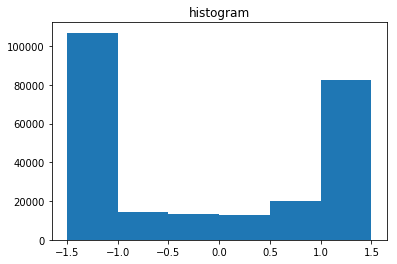

In [12]:
from matplotlib import pyplot as plt 
import numpy as np  

plt.hist(tx[:,11], bins = [-1.5,-1,-0.5,0,0.5,1,1.5]) 
plt.title("histogram") 
plt.show()

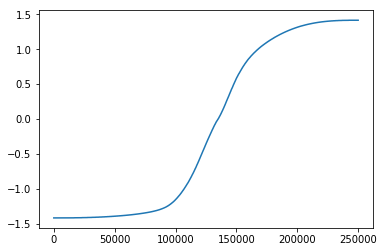

In [15]:
plt.plot(np.sort(tx[:,11]))

In [4]:
y_log = np.copy(y)
y_log = np.where(y_log==-1, 0, y_log)

In [5]:
from implementations import *
minmax = dataset_minmax(tx)

In [6]:
tx_normalized = np.copy(tx)
normalize_dataset(tx_normalized, minmax)

In [7]:
ratio = 0.9
x_train_log_norm, y_train_log_norm, x_test_log_norm, y_test_log_norm = split_data(tx_normalized, y_log, ratio, seed=1)

In [8]:
X = x_train_log_norm
Y = y_train_log_norm
X_t = x_test_log_norm
Y_t = y_test_log_norm

In [9]:
labels = [0, 1]

### Neural Network ###

In [10]:
def create_neural_net(layer_array, input_dims):
    weights = []
    biases = []
    activations = []
    
    for i in range(len(layer_array)):
        node_num = layer_array[i][0]
        weights_of_layer = []
        biases_of_layer = []
        if i == 0:
            last_layer_node_number = input_dims
        else:
            last_layer_node_number = layer_array[i-1][0]
        
        for n in range(0,node_num):
            weights_of_node = []
            for l in range(0, last_layer_node_number):
                weights_of_node.append(1) 
            weights_of_layer.append(weights_of_node)
            biases_of_layer.append(0)
            
        weights.append(weights_of_layer)
        biases.append(biases_of_layer)
        activations.append(layer_array[i][1])
    return [weights, biases, activations]

In [11]:
layer_array = [[len(labels), 'sigmoid']]
input_dims = 30
neural_net = create_neural_net(layer_array, input_dims)

print(' weights:',neural_net[0],'\n\n biases:',neural_net[1],'\n\n activations:', neural_net[2])

 weights: [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]] 

 biases: [[0, 0]] 

 activations: ['sigmoid']


In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def sigmoid_deriv(x):
    return x * (1 - x)

def relu(x):
    if x < 0:
        return 0
    else:
        return x

In [13]:
def predict_ratio(data, neural_net):
    weights = neural_net[0]
    biases = neural_net[1]
    activations = neural_net[2]
    
    layer_num = len(weights)
    
    for l in range(0, layer_num):
        data = np.dot(weights[l], data)
        for t in range(len(data)):
            data[t] += biases[l][t]
        if activations[l] == 'sigmoid':
            data = sigmoid(data)
        elif activations[l] == 'relu':
            data = relu(data)
        else:
            # If not identified, do it with sigmoid
            data = sigmoid(data)
            print('activation function', activations[l], 'cannot be found. Sigmoid is used')   
    return data

def predict(data, neural_net):
    data = predict_ratio(data, neural_net)
    
    class_num = len(data)
    
    highest_class = None
    highest_class_probability = -1
    
    for i in range(0, class_num):
        if highest_class == None:
            highest_class = i
            highest_class_probability = data[i]
        elif data[i] > highest_class_probability:
            highest_class = i
            highest_class_probability = data[i]
            
    return highest_class, highest_class_probability

In [14]:
# Of course, this prediction is absulutly wrong because we didn't trained the network yet
predict(X[1], neural_net)

(0, 0.9993290830985986)

### Training the Network ###

In [15]:
def train_network(X, Y, labels, neural_net, epochs=1000):
    for epoch in range(0, epochs):
        for d in range(0, len(X)):
            prediction = predict_ratio(X[d], neural_net)
            
            # Calculate total error per label
            true_prediction = []
            for i in range(0, len(labels)):
                true_prediction.append(0)
            true_prediction[labels.index(Y[d])] = 1
            
            errors = []
            for t in range(len(prediction)):
                errors.append(true_prediction[t] - prediction[t]) 
            adjust_deriv = errors * sigmoid_deriv(prediction)
            
            for k in range(0, len(adjust_deriv)):
                adjustment = np.dot(X[d], adjust_deriv[k])
                neural_net[0][0][k] += adjustment
    return neural_net

In [22]:
neural_net = train_network(X, Y, labels, neural_net, epochs=30)

In [17]:
def metrics(y_pred, y_test, x_test, predict=predict_labels):
    tp, fp, tn, fn = 0, 0, 0, 0
    y_pred = y_pred
    for i in range(len(y_pred)):
        if (y_pred[i] == 1):
            if (y_test[i] == 1):
                tp += 1
            else:
                fp += 1
        else:
            if (y_test[i] == 1):
                fn += 1
            else:
                tn += 1
    #precision = tp/(tp+fp)
    #recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1_score = 2*tp/(2*tp+tn+fp+fn)

    return accuracy, f1_score

In [23]:
y_pred = []
for i in range(len(Y)):
    y_pred.append((predict(X[i], neural_net))[0])


In [24]:
metrics(y_pred, Y, X)

(0.7493022222222222, 0.2857599987809849)

In [25]:
y_pred = []
for i in range(len(Y_t)):
    y_pred.append((predict(X_t[i], neural_net))[0])


In [26]:
metrics(y_pred, Y_t, X_t)

(0.7493037850558933, 0.2838150532205814)

In [23]:
DATA_TEST_PATH = 'test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [24]:
tx = np.where(tX_test==-999, np.nan, tX_test) # replace -999 value with nan
col_mean = np.nanmean(tx, axis=0)
inds_nan = np.where(np.isnan(tx))
tx[inds_nan] = np.take(col_mean, inds_nan[1])

In [25]:
tx_normalized = np.copy(tx)
normalize_dataset(tx_normalized, minmax)

In [26]:
y_pred = []
for i in range(len(ids_test)):
    y_pred.append((predict(tx_normalized[i], neural_net))[0])

In [29]:
y_pred = np.where(y_pred==0, -1, y_pred)

In [30]:
y_pred

array([-1, -1, -1, ..., -1,  1, -1])

In [31]:

time_day = datetime.datetime.now().day
time_hour = datetime.datetime.now().hour
time_min = datetime.datetime.now().minute
time_second = datetime.datetime.now().second

time = str(time_day)+"-"+str(time_hour)+"-"+str(time_min)+"-"+str(time_second)

OUTPUT_PATH = 'submission'+"_"+str(time)+".csv"
#print(weights_LS.shape)
y_pred = y_pred
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)